In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import json
import mne
import numpy as np
from tqdm import tqdm
import re
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from multiprocessing import Pool
import warnings

warnings.filterwarnings("ignore")

os.chdir('../../..')

# Load Morlet PSDs

In [ ]:
#loaded = np.load('./Generated/Spectrums/psds_array_morlet.npz')
loaded = np.load('./Generated/Spectrums/exec_and_rest_morlets.npz')

results_arr = []

i = 0
while f'power_{i}' in loaded:
    
    power = loaded[f'power_{i}']
    phase = loaded[f'phase_{i}']
    s_id = int(loaded[f'subject_id_{i}'])
    t_id = int(loaded[f'trial_id_{i}'])
    gender = str(loaded[f'gender_{i}'])
    handiness = str(loaded[f'handiness_{i}'])
    age = int(loaded[f'age_{i}'])
    label = int(loaded[f'label_{i}'])
    img = loaded[f'img_{i}']
    task_type = str(loaded[f'task_type_{i}'])
    
    results_arr.append([power, phase, s_id, t_id, gender, handiness, age, label, img, task_type])
    i += 1

power, phase, s_id, t_id, gender, handiness, age, label, img, task_type = results_arr[0]
power.shape

In [ ]:
# Parse into two lists will be used furthere
#psds_array = [item[0] for item in results_arr]
#psds_array = np.array(psds_array)                            # Convert list of PSDs to a numpy array
#psds_array = psds_array.reshape((psds_array.shape[0], -1))   # Vectorize 

metadata = [
    {
        "subject_id": r[2],
        "trial_id":   r[3],
        "gender":     r[4],
        "handiness":  r[5],
        "age":        r[6],
        "label":      r[7],
        "task_type":  r[9],
    }
    for r in results_arr
]

#psds_array.shape

# Load MetaData table

In [4]:
file_path = r'./Supplementary/Experiment_Metadata.xlsx'
meta = pd.read_excel(file_path, header=1).rename(columns={
    'Subject ID'          : 'Subject_id',
    'Время начала записи' : 'Time',
})

meta['Subject_id'] = (
    meta['Subject_id']
    .astype(str)
    .str.extract(r'(\d+)', expand=False)
    .astype('float')
)
meta = meta[meta['Subject_id'].notna()].copy()
meta['Subject_id'] = meta['Subject_id'].astype(int)

s  = meta['Time'].astype(str).str.strip()                    
n  = pd.to_numeric(s, errors='coerce')                        
dt_str = pd.to_datetime(s, errors='coerce', dayfirst=True, infer_datetime_format=True)
dt_num = pd.to_datetime(n, errors='coerce', origin='1899-12-30', unit='D')
dt = dt_str.fillna(dt_num)                                   

meta['Hour'] = dt.dt.hour
meta['Time'] = dt.dt.strftime('%H:%M')

meta_idx = (meta[['Subject_id', 'Hour', 'Time']]
            .dropna(subset=['Hour'])                         
            .drop_duplicates('Subject_id', keep='last'))

m = np.array(metadata, dtype=object)  # [s_id, t_id, gender, handiness, age]
mdf = pd.DataFrame(metadata)
df_out = pd.DataFrame({
    'Subject_ID': mdf['subject_id'].astype(int),
    'Trial_ID'  : mdf['trial_id'].astype(int),
})
df_out = df_out.merge(meta_idx, left_on='Subject_ID', right_on='Subject_id', how='left').drop(columns=['Subject_id'])

df_out['Condition'] = pd.cut(
    df_out['Hour'],
    bins=[-0.1, 10, 18, 24],
    labels=['Other', 'Day', 'Night'],
    right=False,
    include_lowest=True
).astype(object).fillna('Other')

df_out = df_out[['Subject_ID', 'Trial_ID', 'Time', 'Condition']]

print(df_out['Condition'].value_counts(dropna=False))
df_out.head(10)

Condition
Day      357
Night    294
Name: count, dtype: int64


,Subject_ID,Trial_ID,Time,Condition
0,4,2,16:00,Day
1,4,2,16:00,Day
2,4,2,16:00,Day
3,4,2,16:00,Day
4,4,2,16:00,Day
5,4,2,16:00,Day
6,4,2,16:00,Day
7,4,2,16:00,Day
8,4,2,16:00,Day
9,4,2,16:00,Day


In [5]:
cond_dn = df_out['Condition']

subj2cond = (df_out.assign(_m=cond_dn)
             .sort_values(['Subject_ID','Trial_ID'])
             .dropna(subset=['_m'])
             .groupby('Subject_ID')['_m'].first()                     # первая валидная
             .reindex(df_out['Subject_ID'].unique())
             .to_dict())

df_out['Cond_final'] = df_out['Subject_ID'].map(subj2cond)
print('Counts by subject condition:', pd.Series(subj2cond).value_counts().to_dict())
print(df_out['Cond_final'].value_counts(dropna=False))

# Готовим размеры спектра и редукцию по времени (если есть ось T)
first_power = results_arr[0][0]
n_channels, n_freqs = first_power.shape[:2]

# Собираем матрицы "запись × частоты" для Day/Night (по каждому каналу)
day_lists   = [[] for _ in range(n_channels)]
night_lists = [[] for _ in range(n_channels)]
placed = {'Day': 0, 'Night': 0}

for power, *_rest in results_arr:
    s_id = int(_rest[1])           # results_arr: [power, phase, s_id, t_id, ...]
    cond = subj2cond.get(s_id)
    vecs = (power.mean(axis=2) if power.ndim == 3 else power).astype(np.float32, copy=False)  # (C,F)

    if cond == 'Day':
        for ch in range(n_channels): day_lists[ch].append(vecs[ch])
        placed['Day'] += 1
    elif cond == 'Night':
        for ch in range(n_channels): night_lists[ch].append(vecs[ch])
        placed['Night'] += 1

print('Placed trials:', placed)

day_matrices   = {ch: (np.vstack(lst) if lst else np.empty((0, n_freqs), np.float32)) for ch, lst in enumerate(day_lists)}
night_matrices = {ch: (np.vstack(lst) if lst else np.empty((0, n_freqs), np.float32)) for ch, lst in enumerate(night_lists)}

for ch in range(min(5, n_channels)):
    print(f'ch {ch}: day_matrix={day_matrices[ch].shape}, night_matrix={night_matrices[ch].shape}')


Counts by subject condition: {'Day': 9, 'Night': 7}
Cond_final
Day      357
Night    294
Name: count, dtype: int64
Placed trials: {'Day': 357, 'Night': 294}
ch 0: day_matrix=(357, 195), night_matrix=(294, 195)
ch 1: day_matrix=(357, 195), night_matrix=(294, 195)
ch 2: day_matrix=(357, 195), night_matrix=(294, 195)
ch 3: day_matrix=(357, 195), night_matrix=(294, 195)
ch 4: day_matrix=(357, 195), night_matrix=(294, 195)


In [1]:
bands = {
    'Delta': (1, 4),
    'Tetta': (4, 7),
    'Alpha': (7, 13),
    'Beta':  (13, 30),
}

if 'freqs' in globals() and len(freqs) == n_freqs:
    f = np.asarray(freqs)
elif 'psd_freqs' in globals() and len(psd_freqs) == n_freqs:
    f = np.asarray(psd_freqs)
else:
    fmin_guess, fmax_guess = 0.0, 60.0
    f = np.linspace(fmin_guess, fmax_guess, n_freqs, endpoint=False)

band_cols = {name: np.where((f >= lo) & (f < hi))[0] for name, (lo, hi) in bands.items()}

from collections import defaultdict

subj_band_vals = defaultdict(lambda: defaultdict(list))
placed = {'Day': 0, 'Night': 0}

for power, *rest in results_arr:
    s_id = int(rest[1])   
    cond = subj2cond.get(s_id)
    if cond not in ('Day', 'Night'):
        continue

   
    vecs = (power.mean(axis=2) if power.ndim == 3 else power).astype(np.float32, copy=False)  # (C,F)

    for ch in range(n_channels):
        for band, idx in band_cols.items():
            if idx.size == 0:
                continue
            val_trial = float(np.nanmean(vecs[ch, idx]))  # мощность на этот триал в бэнде
            subj_band_vals[(ch, band, cond)][s_id].append(val_trial)

    placed[cond] += 1

print('Placed trials:', placed)

subject_vectors = {}  

for ch in range(n_channels):
    for band in bands.keys():
        key_day   = (ch, band, 'Day')
        key_night = (ch, band, 'Night')

        # среднее по триалам данного субъекта
        day_ids, night_ids = [], []
        x_vals, y_vals = [], []

        for sid, vals in subj_band_vals[key_day].items():
            if len(vals):
                day_ids.append(sid)
                x_vals.append(float(np.nanmean(vals)))

        for sid, vals in subj_band_vals[key_night].items():
            if len(vals):
                night_ids.append(sid)
                y_vals.append(float(np.nanmean(vals)))

        subject_vectors[(ch, band)] = {
            'day':   np.array(x_vals, dtype=float),
            'night': np.array(y_vals, dtype=float),
            'day_ids':   day_ids,
            'night_ids': night_ids,
        }



NameError: name 'np' is not defined

In [27]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.power import TTestIndPower

alpha = 0.05
power_calc = TTestIndPower()

def hedges_g(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    if vx == 0 and vy == 0:
        return np.sign(np.mean(x)-np.mean(y)) * 0.0
    sp = np.sqrt(((nx-1)*vx + (ny-1)*vy) / (nx + ny - 2))
    if sp == 0:
        return np.nan
    d = (np.mean(x) - np.mean(y)) / sp                   # Day − Night
    J = 1 - 3/(4*(nx + ny) - 9) if (nx+ny) > 2 else 1.0  # small-sample correction
    return J * d

rows = []
for (ch, band), vecs in subject_vectors.items():
    x = np.asarray(vecs['day'], float)    # длина ≈ 9
    y = np.asarray(vecs['night'], float)  # длина ≈ 7

    n1, n2 = len(x), len(y)
    if n1 == 0 or n2 == 0:
        continue

    # Welch's t-test
    try:
        t_stat, p_val = stats.ttest_ind(x, y, equal_var=False, nan_policy='omit')
    except Exception:
        t_stat, p_val = np.nan, np.nan

    # Effect size (Hedges' g) — знак = Day − Night
    g = hedges_g(x, y)

    try:
        ratio = n2 / max(n1, 1)
        power = power_calc.solve_power(effect_size=abs(g), nobs1=n1, ratio=ratio,
                                       alpha=alpha, alternative='two-sided')
    except Exception:
        power = np.nan

    rows.append({
        'channel': ch,
        'band': band,
        'n_day': n1,
        'n_night': n2,
        'mean_day': float(np.nanmean(x)) if n1 else np.nan,
        'mean_night': float(np.nanmean(y)) if n2 else np.nan,
        'delta_day_minus_night': float(np.nanmean(x) - np.nanmean(y)) if (n1 and n2) else np.nan,
        't_stat': float(t_stat) if np.isfinite(t_stat) else np.nan,
        'p_value': float(p_val) if np.isfinite(p_val) else np.nan,
        'hedges_g': float(g) if np.isfinite(g) else np.nan,
        'power': float(power) if np.isfinite(power) else np.nan,
        'sig_alpha_0.05': bool((p_val <= 0.05) if np.isfinite(p_val) else False),
        'sig_alpha_0.01': bool((p_val <= 0.01) if np.isfinite(p_val) else False),
        'sig_and_power': bool((p_val <= 0.05) and (power >= 0.8)) if (np.isfinite(p_val) and np.isfinite(power)) else False,
    })

band_table = pd.DataFrame(rows).sort_values(['band', 'p_value', 'power'], ascending=[True, True, False]).reset_index(drop=True)
print(band_table.head(12))

# при желании — сохранить рядом с исходными файлами
from pathlib import Path
outdir = Path(file_path).parent
band_table.to_csv(outdir / 'band_table_by_channel.csv', index=False)
band_table.to_excel(outdir / 'band_table_by_channel.xlsx', index=False)


    channel   band  n_day  n_night  mean_day  mean_night  \
0        16  Alpha      9        7  0.275459    0.166873   
1         1  Alpha      9        7  0.204497    0.134837   
2        43  Alpha      9        7  0.192508    0.129726   
3        29  Alpha      9        7  0.211379    0.134440   
4        60  Alpha      9        7  0.159002    0.114830   
5        10  Alpha      9        7  0.153464    0.098394   
6        32  Alpha      9        7  0.145341    0.106041   
7        28  Alpha      9        7  0.161832    0.118684   
8        33  Alpha      9        7  0.160005    0.117987   
9        21  Alpha      9        7  0.160047    0.100431   
10       53  Alpha      9        7  0.171462    0.121395   
11       61  Alpha      9        7  0.178811    0.131778   

    delta_day_minus_night    t_stat   p_value  hedges_g     power  \
0                0.108586  1.141333  0.277907  0.493825  0.149801   
1                0.069660  1.126487  0.284503  0.485675  0.146450   
2           

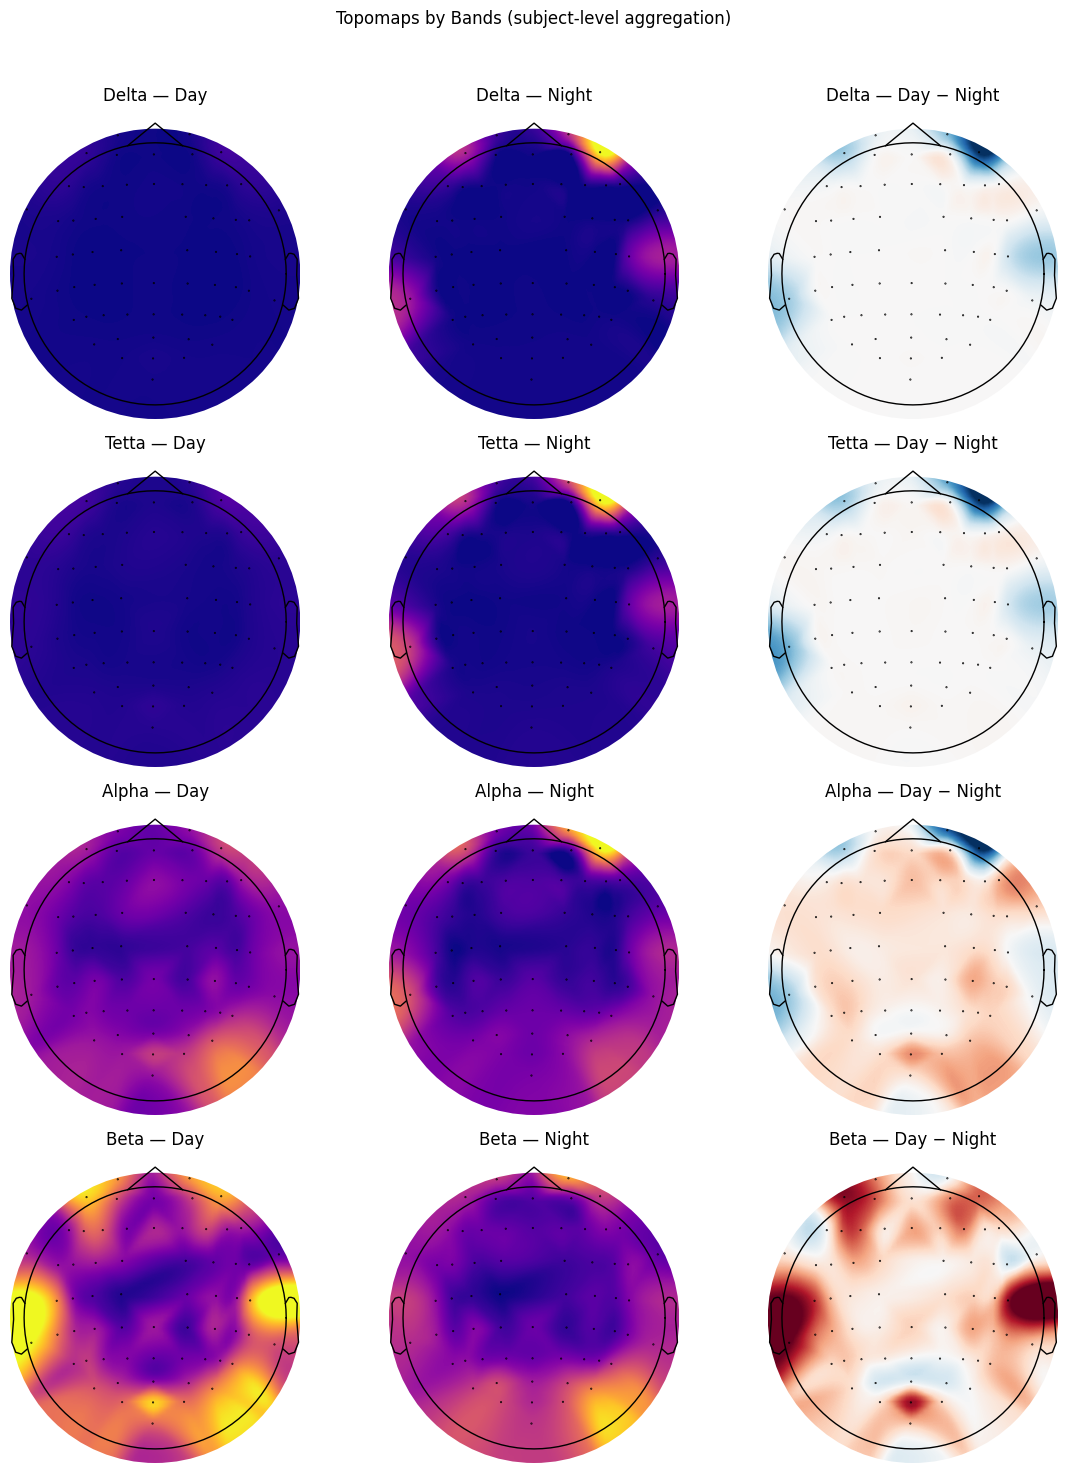

In [30]:

info       = eeg.info
ch_names   = info['ch_names']
n_channels = len(ch_names)

bands_to_plot = ['Delta', 'Tetta', 'Alpha', 'Beta']

def build_maps_from_subject_vectors(subject_vectors, band_name, n_channels, agg='mean', winsor=None):

    day   = np.full(n_channels, np.nan, float)
    night = np.full(n_channels, np.nan, float)

    for ch in range(n_channels):
        vec = subject_vectors.get((ch, band_name))
        if not vec:
            continue
        x = np.asarray(vec['day'],   float)
        y = np.asarray(vec['night'], float)

        if winsor is not None and 0.5 < winsor < 1.0:
            def _wins(v, q):
                if v.size == 0: return v
                lo, hi = np.nanquantile(v, 1-q, method='weibull'), np.nanquantile(v, q, method='weibull')
                return np.clip(v, lo, hi)
            x = _wins(x, winsor)
            y = _wins(y, winsor)

        if agg == 'median':
            day[ch]   = float(np.nanmedian(x)) if x.size else np.nan
            night[ch] = float(np.nanmedian(y)) if y.size else np.nan
        else:
            day[ch]   = float(np.nanmean(x)) if x.size else np.nan
            night[ch] = float(np.nanmean(y)) if y.size else np.nan

    diff = day - night  # Day − Night
    return day, night, diff

def vlim_pair(a, b):
    
    a = np.array(a, float); b = np.array(b, float)
    mask = np.isfinite(a) | np.isfinite(b)
    if not np.any(mask):
        return (-1.0, 1.0)
    lo = float(np.nanmin([np.nanmin(a[mask]), np.nanmin(b[mask])]))
    hi = float(np.nanmax([np.nanmax(a[mask]), np.nanmax(b[mask])]))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return (-1.0, 1.0)
    return (lo, hi)


AGGREGATOR = 'mean'    
WINSOR_Q   = None      

fig, axs = plt.subplots(len(bands_to_plot), 3, figsize=(12, 3.6*len(bands_to_plot)))
axs = np.atleast_2d(axs)

for row, band_name in enumerate(bands_to_plot):
    day_map, night_map, diff_map = build_maps_from_subject_vectors(
        subject_vectors, band_name, n_channels, agg=AGGREGATOR, winsor=WINSOR_Q
    )

    vmin, vmax = vlim_pair(day_map, night_map)  
    vmax_abs = np.nanmax(np.abs(diff_map)) if np.any(np.isfinite(diff_map)) else 1.0
    if not np.isfinite(vmax_abs) or vmax_abs == 0:
        vmax_abs = 1.0
    vlim_diff = (-vmax_abs, vmax_abs)         

    mne.viz.plot_topomap(day_map,   info, axes=axs[row, 0], show=False,
                         cmap='plasma', contours=0, vlim=(vmin, vmax))
    axs[row, 0].set_title(f"{band_name} — Day")

    mne.viz.plot_topomap(night_map, info, axes=axs[row, 1], show=False,
                         cmap='plasma', contours=0, vlim=(vmin, vmax))
    axs[row, 1].set_title(f"{band_name} — Night")

    mne.viz.plot_topomap(diff_map,  info, axes=axs[row, 2], show=False,
                         cmap='RdBu_r', contours=0, vlim=vlim_diff)
    axs[row, 2].set_title(f"{band_name} — Day − Night")

plt.suptitle("Topomaps by Bands (subject-level aggregation)", y=1.02)
plt.tight_layout()
plt.show()


Welch t-test 

In [22]:
from scipy import stats
from statsmodels.stats.power import TTestIndPower
from datetime import datetime
bands = {
    'Delta': (1, 4),
    'Tetta': (4, 7),
    'Alpha': (7, 13),
    'Beta': (13, 30)
}
alpha = 0.05
freqs = np.linspace(2, 40, 40*2)
band_idx = {b: np.where((freqs >= lo) & (freqs < hi))[0] for b,(lo,hi) in bands.items()}
def effect_size_d(x, y):
    # Cohen's d: разница средних / std
    nx, ny = len(x), len(y)
    sp = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / sp
band_rows = []




power_calc = TTestIndPower()
for ch, D in day_matrices.items():
    N = night_matrices.get(ch, np.empty((0, len(freqs))))
    if D.size == 0 or N.size == 0:
        continue
    for b, idx in band_idx.items():
        if len(idx) == 0:
            continue
        x = np.nanmean(D[:, idx], axis=1)  # средняя мощность в диапазоне по записи
        y = np.nanmean(N[:, idx], axis=1)

        t, p = stats.ttest_ind(x, y, equal_var=False, nan_policy='omit')
        d = effect_size_d(x, y)
        try:
            n1, n2 = len(x), len(y)
            ratio = n2 / n1 if n1 > 0 else 1.0
            power = power_calc.solve_power(effect_size=np.abs(d), nobs1=n1, ratio=ratio,
                                           alpha=alpha, alternative='two-sided')
        except Exception:
            power = np.nan
        i = True
        band_rows.append({
            "channel": ch,
            "band": b,
            "n_day": len(x),
            "n_night": len(y),
            "t_stat": float(t),
            "p_value": float(p),
            "power": float(power) if np.isfinite(power) else np.nan,
            "mean_day": float(np.nanmean(x)),
            "mean_night": float(np.nanmean(y)),
            "HYP": bool(i) if power > p and p <= 0.01 else not i
        })

band_df = pd.DataFrame(band_rows).sort_values(["p_value", "power"])
print(band_df.head(15))
from pathlib import Path
outdir = Path(file_path).parent 
band_df.to_csv(outdir / "band_stats.csv", index=False)
band_df.to_excel(outdir / "band_stats.xlsx", index=False)

     channel   band  n_day  n_night    t_stat       p_value     power  \
130       32  Alpha    357      294  7.533327  1.764936e-13  1.000000   
242       60  Alpha    357      294  7.535605  1.855626e-13  1.000000   
146       36  Alpha    357      294  7.201993  1.683678e-12  1.000000   
34         8  Alpha    357      294  6.746243  3.380398e-11  0.999998   
43        10   Beta    357      294  6.764606  4.242212e-11  0.999991   
142       35  Alpha    357      294  6.636588  7.033825e-11  0.999995   
7          1   Beta    357      294  6.514743  1.823946e-10  0.999980   
106       26  Alpha    357      294  6.309783  5.324262e-10  0.999993   
243       60   Beta    357      294  6.155350  1.336225e-09  0.999964   
87        21   Beta    357      294  6.061479  2.699480e-09  0.999886   
175       43   Beta    357      294  6.048312  2.806725e-09  0.999895   
215       53   Beta    357      294  5.904368  6.286558e-09  0.999837   
131       32   Beta    357      294  5.753511  1.38

In [7]:
from scipy.stats import ttest_ind
import numpy as np

def bootstrap_power(x, y, n_iter=1000, alpha=0.05, test='t'):
    x = np.asarray(x)
    y = np.asarray(y)
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]
    if len(x) == 0 or len(y) == 0:
        return np.nan

    count = 0
    for _ in range(n_iter):
        # случайная подвыборка того же размера (с возвращением)
        xs = np.random.choice(x, size=len(x), replace=True)
        ys = np.random.choice(y, size=len(y), replace=True)
        if test == 't':
            _, p = ttest_ind(xs, ys, equal_var=False)
        elif test == 'mw':
            from scipy.stats import mannwhitneyu
            _, p = mannwhitneyu(xs, ys, alternative='two-sided')
        else:
            raise ValueError("test must be 't' or 'mw'")
        if p < alpha:
            count += 1

    return count / n_iter

In [8]:
path = "./Generated/Data/S_1/Trial_1/EEG_clean.fif"  


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    raw = mne.io.read_raw_fif(path, preload=True, verbose=False)


raw.pick_types(eeg=True)


eeg = raw

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [9]:
bands = {
    'Delta': (1, 4),
    'Tetta': (4, 7),
    'Lower Alpha': (7, 7.5),
    'Upper Alpha': (7.5, 13),
    'Beta': (13, 30)
}

band_rows = []

power_calc = TTestIndPower()
band_idx = {b: np.where((freqs >= lo) & (freqs < hi))[0] for b,(lo,hi) in bands.items()}

for ch, D in day_matrices.items():
    N = night_matrices.get(ch, np.empty((0, len(freqs))))
    if D.size == 0 or N.size == 0:
        continue
    for b, idx in band_idx.items():
        if len(idx) == 0:
            continue
        x = np.nanmean(D[:, idx], axis=1)  # средняя мощность в диапазоне по записи
        y = np.nanmean(N[:, idx], axis=1)

        t, p = stats.ttest_ind(x, y, equal_var=False, nan_policy='omit')
        d = effect_size_d(x, y)
        try:
            n1, n2 = len(x), len(y)
            ratio = n2 / n1 if n1 > 0 else 1.0
            #power = power_calc.solve_power(effect_size=np.abs(d), nobs1=n1, ratio=ratio,
                                           #alpha=alpha, alternative='two-sided')
            power = bootstrap_power(x, y, n_iter=1000, alpha=0.05, test='t')
        except Exception:
            power = np.nan
        i = True
        band_rows.append({
            "channel": ch,
            "band": b,
            "n_day": len(x),
            "n_night": len(y),
            "t_stat": float(t),
            "p_value": float(p),
            "power": float(power) if np.isfinite(power) else np.nan,
            "mean_day": float(np.nanmean(x)),
            "mean_night": float(np.nanmean(y)),
            "HYP": bool(i) if power > p and p <= 0.01 else not i
        })
band_df_fr = pd.DataFrame(band_rows).sort_values(["p_value", "power"])
print(band_df_fr.head(15))
from pathlib import Path
outdir = Path(file_path).parent  
band_df_fr.to_csv(outdir / "band_stats_morlet_exec_rest_fr.csv", index=False)
band_df_fr.to_excel(outdir / "band_stats_morlet_exec_rest_fr.xlsx", index=False)


     channel         band  n_day  n_night    t_stat       p_value  power  \
303       60  Upper Alpha    357      294  7.869417  1.649626e-14    1.0   
163       32  Upper Alpha    357      294  7.827884  2.146487e-14    1.0   
183       36  Upper Alpha    357      294  7.351898  6.000333e-13    1.0   
43         8  Upper Alpha    357      294  6.914125  1.137199e-11    1.0   
178       35  Upper Alpha    357      294  6.808717  2.329789e-11    1.0   
54        10         Beta    357      294  6.764606  4.242212e-11    1.0   
133       26  Upper Alpha    357      294  6.704686  4.509813e-11    1.0   
9          1         Beta    357      294  6.514743  1.823946e-10    1.0   
304       60         Beta    357      294  6.155350  1.336225e-09    1.0   
168       33  Upper Alpha    357      294  6.056130  2.530797e-09    1.0   
109       21         Beta    357      294  6.061479  2.699480e-09    1.0   
219       43         Beta    357      294  6.048312  2.806725e-09    1.0   
269       53

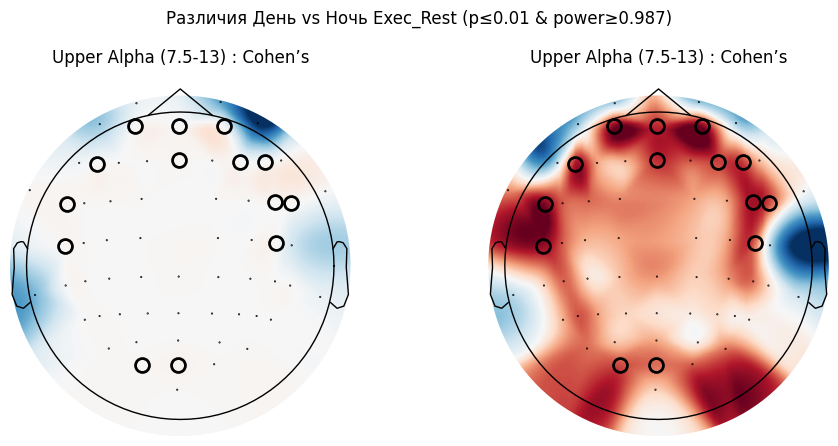

In [10]:

df_beta = band_df_fr[band_df_fr['band']=='Upper Alpha'].copy()   

n_channels = len(eeg.info['ch_names'])
delta_vec  = np.full(n_channels, np.nan)
d_vec      = np.full(n_channels, np.nan)
mask_sig   = np.zeros(n_channels, dtype=bool)

for _, r in df_beta.iterrows():
    ch = int(r['channel'])
    if 0 <= ch < n_channels:
        # Δ = mean_day − mean_night
        delta_vec[ch] = float(r['mean_day']) - float(r['mean_night'])

        # t ≈ d / sqrt(1/n1 + 1/n2)  ->  d ≈ t * sqrt(1/n1 + 1/n2)
        n1, n2 = float(r['n_day']), float(r['n_night'])
        d_vec[ch] = float(r['t_stat']) * np.sqrt(1.0/n1 + 1.0/n2)

        if (float(r['p_value']) <= 0.01) and (float(r['power']) >= 0.987):
            mask_sig[ch] = True

def sym_vlim(v):
    vmax = np.nanmax(np.abs(v))
    return (-vmax, vmax) if np.isfinite(vmax) and vmax>0 else (-1,1)

# 2) рисуем: Δ и d (симметричные шкалы, красный = днём больше)
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

mne.viz.plot_topomap(
    delta_vec, eeg.info, axes=axes[0], show=False, cmap='RdBu_r',
    vlim=sym_vlim(delta_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[0].set_title("Upper Alpha (7.5-13) : Cohen’s")

mne.viz.plot_topomap(
    d_vec, eeg.info, axes=axes[1], show=False, cmap='RdBu_r',
    vlim=sym_vlim(d_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[1].set_title("Upper Alpha (7.5-13) : Cohen’s")

plt.suptitle("Различия День vs Ночь Exec_Rest (p≤0.01 & power≥0.987)")
plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.power import TTestIndPower
power_calc = TTestIndPower()
rows = []
for ch, D in day_matrices.items():
    N = night_matrices.get(ch, np.empty((0, len(freqs))))
    if D.size == 0 or N.size == 0:
        continue
    for b, idx in band_idx.items():
        if idx.size == 0:
            continue
        # средняя мощность по частотам бэнда для каждой записи 
        x = np.nanmean(D[:, idx], axis=1)
        y = np.nanmean(N[:, idx], axis=1)

        # уберём NaN/inf
        x = x[np.isfinite(x)]
        y = y[np.isfinite(y)]
        if len(x) == 0 or len(y) == 0:
            continue

        # Mann–Whitney U, двусторонний
        U, p = mannwhitneyu(x, y, alternative='two-sided')

        d = effect_size_d(x, y)

        ratio = len(y) / len(x)
        power_val = power_calc.solve_power(effect_size=abs(d),
                                               nobs1=len(x), ratio=ratio,
                                               alpha=0.05, alternative='two-sided')
        i = True
        rows.append({
            "channel": ch,
            "band": b,
            "n_day": len(x),
            "n_night": len(y),
            "U_stat": float(U),
            "p_value": float(p),
            "power": float(power_val) if np.isfinite(power_val) else np.nan,
            "median_day": float(np.median(x)),
            "median_night": float(np.median(y)),
            "diff_median": float(np.median(x) - np.median(y)),
            "HYP": bool(i) if power_val > float(p) and float(p) <= 0.01 else not i
        })

mw_df = pd.DataFrame(rows).sort_values("p_value").reset_index(drop=True)
print(mw_df.head(15).to_string(index=False))


mw_df.to_csv("mannwhitney_band_stats.csv", index=False)


 channel        band  n_day  n_night  U_stat      p_value    power  median_day  median_night  diff_median  HYP
      21 Lower Alpha    357      294 86331.0 1.300001e-45 0.346416    0.108325      0.072016     0.036309 True
      21       Tetta    357      294 85986.0 1.007445e-44 0.075553    0.123324      0.080853     0.042471 True
      21       Delta    357      294 83837.0 2.185145e-39 0.061141    0.147951      0.098328     0.049623 True
      54 Lower Alpha    357      294 82729.0 8.997799e-37 0.757319    0.124846      0.083433     0.041412 True
      21 Upper Alpha    357      294 82519.0 2.749266e-36 0.996936    0.093754      0.063378     0.030376 True
       1       Delta    357      294 82252.0 1.124973e-35 0.074004    0.296002      0.191507     0.104495 True
      28       Tetta    357      294 82243.0 1.179437e-35 0.342082    0.220930      0.157185     0.063745 True
      28 Lower Alpha    357      294 82234.0 1.236520e-35 0.743821    0.190119      0.139131     0.050988 True
 

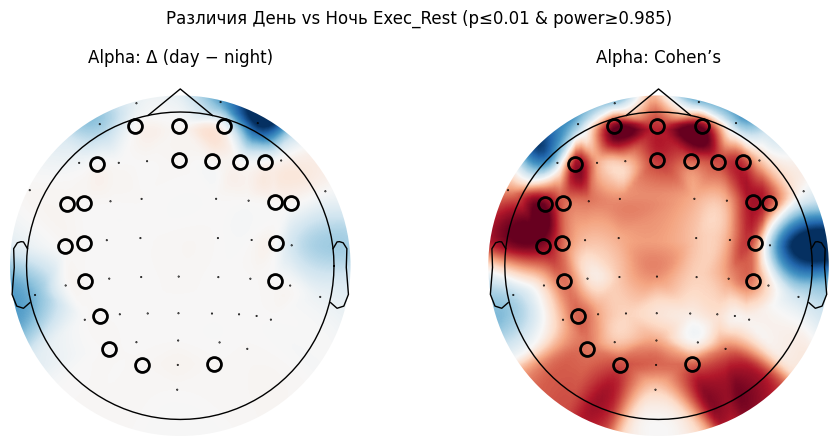

In [19]:


df_beta = band_df[band_df['band']=='Alpha'].copy()   
n_channels = len(eeg.info['ch_names'])
delta_vec  = np.full(n_channels, np.nan)
d_vec      = np.full(n_channels, np.nan)
mask_sig   = np.zeros(n_channels, dtype=bool)

for _, r in df_beta.iterrows():
    ch = int(r['channel'])
    if 0 <= ch < n_channels:
        # Δ = mean_day − mean_night
        delta_vec[ch] = float(r['mean_day']) - float(r['mean_night'])

        # t ≈ d / sqrt(1/n1 + 1/n2)  ->  d ≈ t * sqrt(1/n1 + 1/n2)
        n1, n2 = float(r['n_day']), float(r['n_night'])
        d_vec[ch] = float(r['t_stat']) * np.sqrt(1.0/n1 + 1.0/n2)

        # маска значимости
        if (float(r['p_value']) <= 0.01) and (float(r['power']) >= 0.985):
            mask_sig[ch] = True

def sym_vlim(v):
    vmax = np.nanmax(np.abs(v))
    return (-vmax, vmax) if np.isfinite(vmax) and vmax>0 else (-1,1)

# 2) рисуем: Δ и d (симметричные шкалы, красный = днём больше)
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

mne.viz.plot_topomap(
    delta_vec, eeg.info, axes=axes[0], show=False, cmap='RdBu_r',
    vlim=sym_vlim(delta_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[0].set_title("Alpha: Δ (day − night)")

mne.viz.plot_topomap(
    d_vec, eeg.info, axes=axes[1], show=False, cmap='RdBu_r',
    vlim=sym_vlim(d_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[1].set_title("Alpha: Cohen’s")

plt.suptitle("Различия День vs Ночь Exec_Rest (p≤0.01 & power≥0.985)")
plt.tight_layout()
plt.show()


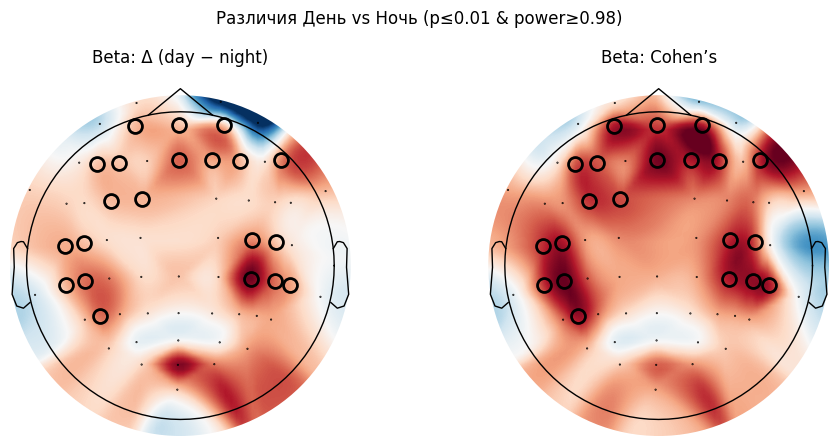

In [13]:

df_beta = band_df[band_df['band']=='Beta'].copy()  

n_channels = len(eeg.info['ch_names'])
delta_vec  = np.full(n_channels, np.nan)
d_vec      = np.full(n_channels, np.nan)
mask_sig   = np.zeros(n_channels, dtype=bool)

for _, r in df_beta.iterrows():
    ch = int(r['channel'])
    if 0 <= ch < n_channels:
        # Δ = mean_day − mean_night
        delta_vec[ch] = float(r['mean_day']) - float(r['mean_night'])

        # t ≈ d / sqrt(1/n1 + 1/n2)  ->  d ≈ t * sqrt(1/n1 + 1/n2)
        n1, n2 = float(r['n_day']), float(r['n_night'])
        d_vec[ch] = float(r['t_stat']) * np.sqrt(1.0/n1 + 1.0/n2)

        if (float(r['p_value']) <= 0.01) and (float(r['power']) >= 0.98):
            mask_sig[ch] = True

def sym_vlim(v):
    vmax = np.nanmax(np.abs(v))
    return (-vmax, vmax) if np.isfinite(vmax) and vmax>0 else (-1,1)

# 2) рисуем: Δ и d (симметричные шкалы, красный = днём больше)
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

mne.viz.plot_topomap(
    delta_vec, eeg.info, axes=axes[0], show=False, cmap='RdBu_r',
    vlim=sym_vlim(delta_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[0].set_title("Beta: Δ (day − night)")

mne.viz.plot_topomap(
    d_vec, eeg.info, axes=axes[1], show=False, cmap='RdBu_r',
    vlim=sym_vlim(d_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[1].set_title("Beta: Cohen’s")

plt.suptitle("Различия День vs Ночь (p≤0.01 & power≥0.98)")
plt.tight_layout()
plt.show()


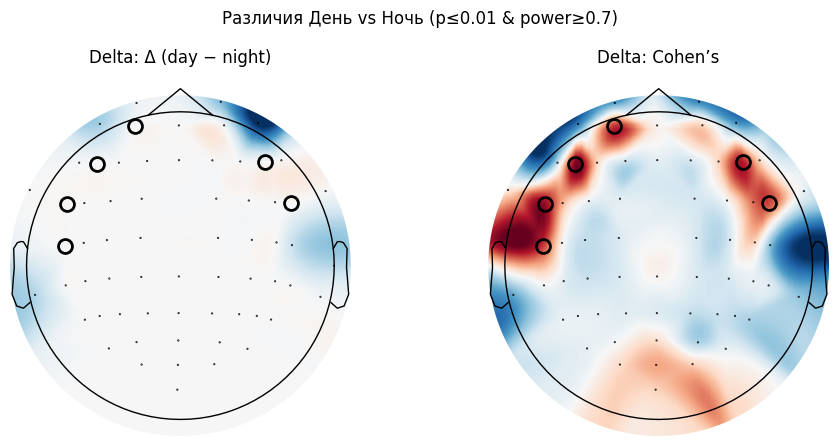

In [14]:
df_beta = band_df[band_df['band']=='Delta'].copy()   # если у тебя welch_df, подставь его

n_channels = len(eeg.info['ch_names'])
delta_vec  = np.full(n_channels, np.nan)
d_vec      = np.full(n_channels, np.nan)
mask_sig   = np.zeros(n_channels, dtype=bool)

for _, r in df_beta.iterrows():
    ch = int(r['channel'])
    if 0 <= ch < n_channels:
        # Δ = mean_day − mean_night
        delta_vec[ch] = float(r['mean_day']) - float(r['mean_night'])

        # t ≈ d / sqrt(1/n1 + 1/n2)  ->  d ≈ t * sqrt(1/n1 + 1/n2)
        n1, n2 = float(r['n_day']), float(r['n_night'])
        d_vec[ch] = float(r['t_stat']) * np.sqrt(1.0/n1 + 1.0/n2)

        if (float(r['p_value']) <= 0.01) and (float(r['power']) >= 0.7):
            mask_sig[ch] = True

def sym_vlim(v):
    vmax = np.nanmax(np.abs(v))
    return (-vmax, vmax) if np.isfinite(vmax) and vmax>0 else (-1,1)

# 2) рисуем: Δ и d (симметричные шкалы, красный = днём больше)
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

mne.viz.plot_topomap(
    delta_vec, eeg.info, axes=axes[0], show=False, cmap='RdBu_r',
    vlim=sym_vlim(delta_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[0].set_title("Delta: Δ (day − night)")

mne.viz.plot_topomap(
    d_vec, eeg.info, axes=axes[1], show=False, cmap='RdBu_r',
    vlim=sym_vlim(d_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[1].set_title("Delta: Cohen’s")

plt.suptitle("Различия День vs Ночь (p≤0.01 & power≥0.7)")
plt.tight_layout()
plt.show()


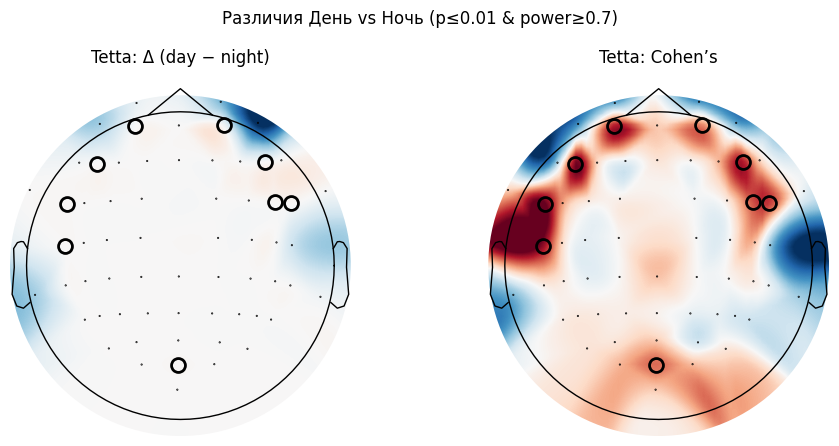

In [15]:

df_beta = band_df[band_df['band']=='Tetta'].copy()   

n_channels = len(eeg.info['ch_names'])
delta_vec  = np.full(n_channels, np.nan)
d_vec      = np.full(n_channels, np.nan)
mask_sig   = np.zeros(n_channels, dtype=bool)

for _, r in df_beta.iterrows():
    ch = int(r['channel'])
    if 0 <= ch < n_channels:
        # Δ = mean_day − mean_night
        delta_vec[ch] = float(r['mean_day']) - float(r['mean_night'])
        n1, n2 = float(r['n_day']), float(r['n_night'])
        d_vec[ch] = float(r['t_stat']) * np.sqrt(1.0/n1 + 1.0/n2)
        if (float(r['p_value']) <= 0.01) and (float(r['power']) >= 0.7):
            mask_sig[ch] = True

def sym_vlim(v):
    vmax = np.nanmax(np.abs(v))
    return (-vmax, vmax) if np.isfinite(vmax) and vmax>0 else (-1,1)

# 2) рисуем: Δ и d (симметричные шкалы, красный = днём больше)
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

mne.viz.plot_topomap(
    delta_vec, eeg.info, axes=axes[0], show=False, cmap='RdBu_r',
    vlim=sym_vlim(delta_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[0].set_title("Tetta: Δ (day − night)")

mne.viz.plot_topomap(
    d_vec, eeg.info, axes=axes[1], show=False, cmap='RdBu_r',
    vlim=sym_vlim(d_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[1].set_title("Tetta: Cohen’s")

plt.suptitle("Различия День vs Ночь (p≤0.01 & power≥0.7)")
plt.tight_layout()
plt.show()


In [16]:
from pathlib import Path

path = './Generated/Data/S_1/Trial_1/EEG_clean.fif'  # твой путь

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    raw = mne.io.read_raw_fif(path, preload=True, verbose=False)

eeg = raw.copy().pick_types(eeg=True)        
ch_names = eeg.info['ch_names']

eeg.set_montage('standard_1020', on_missing='warn', match_case=False)



NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


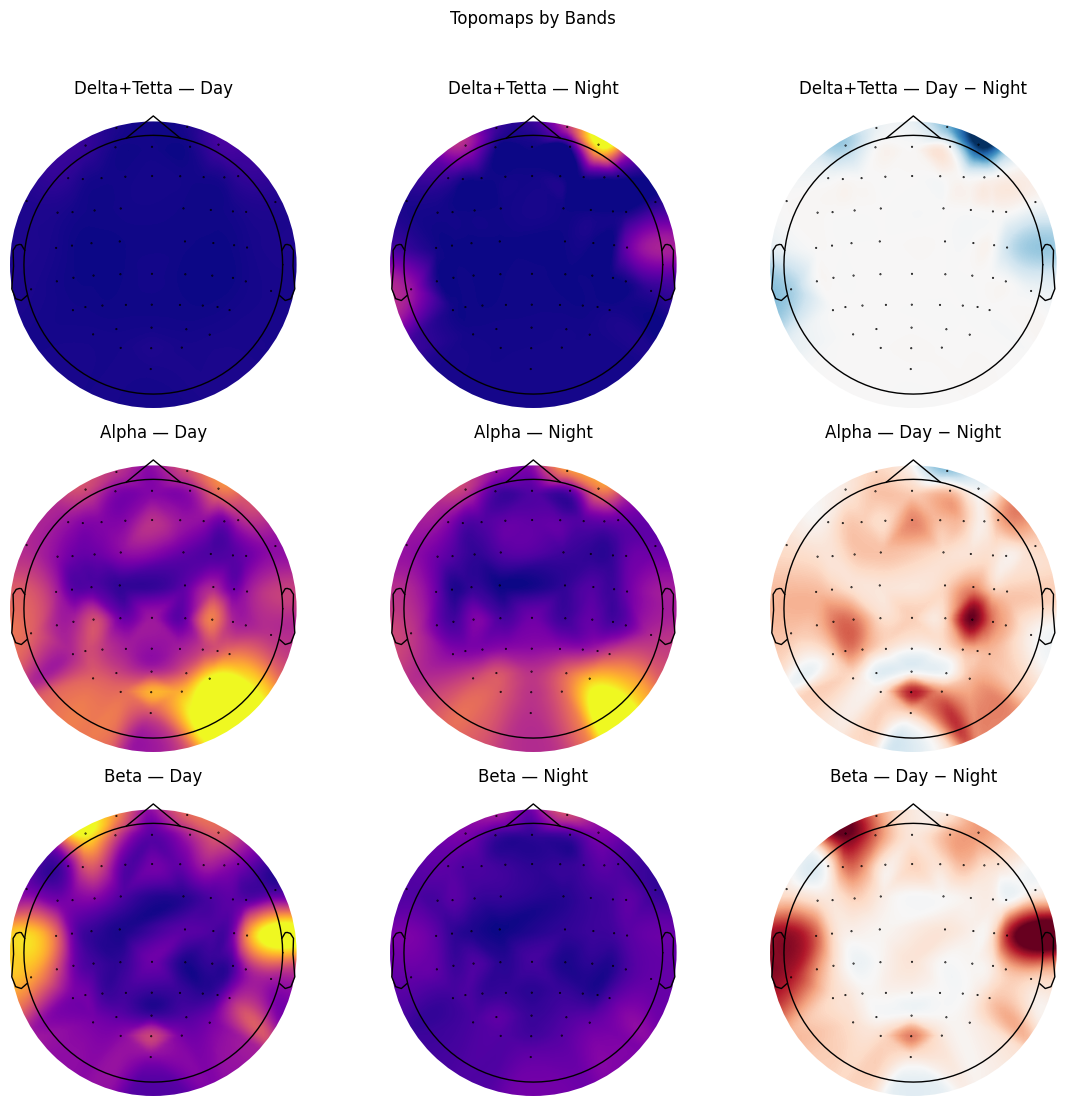

In [18]:
info       = eeg.info
ch_names   = info['ch_names']
n_channels = len(ch_names)

def _first_nonempty_shape(M):
    for v in M.values():
        if isinstance(v, np.ndarray) and v.size:
            return v.shape
    return None

shape_day   = _first_nonempty_shape(day_matrices)
shape_night = _first_nonempty_shape(night_matrices)
assert shape_day or shape_night, "Обе матрицы пустые."

nF_mat = (shape_day or shape_night)[1]


if 'psd' in globals() and hasattr(psd, 'freqs') and len(psd.freqs) >= nF_mat:
    freqs = np.asarray(psd.freqs[:nF_mat], float)
elif 'welch_df' in globals():
    freqs = np.sort(welch_df['freq_hz'].unique())
    if len(freqs) != nF_mat:
        freqs = np.linspace(freqs.min(), freqs.max(), nF_mat)
else:
    freqs = np.linspace(1, 40, nF_mat)  # резерв, но теперь длина точно совпадает!



band_limits = {
    'Delta+Tetta': (1, 7),
    'Alpha':       (7, 13),
    'Beta':        (13, 30),
}

def band_idx(freqs, fmin, fmax):
    idx = np.where((freqs >= fmin) & (freqs <= fmax))[0]
    return idx

def mean_over_band(mat, idx):
    if mat is None or mat.size == 0 or idx.size == 0:
        return np.nan
    # матрица обязана иметь ширину len(freqs)
    if mat.shape[1] != len(freqs):
        return np.nan
    return float(np.nanmean(np.nanmean(mat[:, idx], axis=1)))

def build_maps(dayM, nightM, freqs, fmin, fmax, n_channels):
    idx = band_idx(freqs, fmin, fmax)
    day   = np.full(n_channels, np.nan)
    night = np.full(n_channels, np.nan)

    for ch in range(n_channels):
        D = dayM.get(ch, None)
        N = nightM.get(ch, None)
        day[ch]   = mean_over_band(D, idx)
        night[ch] = mean_over_band(N, idx)
    diff = day - night
    return day, night, diff, idx

def vlim_pair(a, b):
    a_f = np.array(a, float); b_f = np.array(b, float)
    if np.isfinite(a_f).sum() < 1 or np.isfinite(b_f).sum() < 1:
        return (-1.0, 1.0)
    lo = float(np.nanmin([np.nanmin(a_f), np.nanmin(b_f)]))
    hi = float(np.nanmax([np.nanmax(a_f), np.nanmax(b_f)]))
    return (lo, hi) if hi > lo else (-1.0, 1.0)


fig, axs = plt.subplots(len(band_limits), 3, figsize=(12, 3.6*len(band_limits)))
axs = np.atleast_2d(axs)
row = 0
for band_name, (fmin_band, fmax_band) in band_limits.items():
    day_map, night_map, diff_map, idx = build_maps(day_matrices, night_matrices, freqs,
                                                       fmin_band, fmax_band, n_channels)

    vmin, vmax = vlim_pair(day_map, night_map)
    vmax_abs = float(np.nanmax(np.abs(diff_map))) if np.isfinite(np.nanmax(np.abs(diff_map))) else 1.0
    vlim_diff = (-vmax_abs, vmax_abs)

    mne.viz.plot_topomap(day_map, info, axes=axs[row, 0], show=False,
                             cmap='plasma', contours=0, vlim=(vmin, vmax))
    axs[row, 0].set_title(f"{band_name} — Day")

    mne.viz.plot_topomap(night_map, info, axes=axs[row, 1], show=False,
                             cmap='plasma', contours=0, vlim=(vmin, vmax))
    axs[row, 1].set_title(f"{band_name} — Night")

    mne.viz.plot_topomap(diff_map, info, axes=axs[row, 2], show=False,
                             cmap='RdBu_r', contours=0, vlim=vlim_diff)
    axs[row, 2].set_title(f"{band_name} — Day − Night")

    row += 1


plt.suptitle(f"Topomaps by Bands", y=1.02)
plt.tight_layout()
plt.show()
